<a href="https://colab.research.google.com/github/2303A52131/Explainable_AI/blob/main/EX_AI_RESEARCH_AND_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Part 0 — Install required packages
!pip install xgboost shap lime imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=06f434c47fd86ab300649a8e39826685ca9031a00259ee58d3ccd479fa373958
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
# Part 1 — Upload dataset
from google.colab import files
import pandas as pd

In [3]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv("/content/archive.zip")
print("/content/archive.zip", filename)
print(df.shape)
display(df.head())

Saving archive.zip to archive (1).zip
/content/archive.zip archive (1).zip
(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Part 2 — Encode target column
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df['Attrition'] = le_target.fit_transform(df['Attrition'])  # Yes=1, No=0
print("Target value counts:\n", df['Attrition'].value_counts())

Target value counts:
 Attrition
0    1233
1     237
Name: count, dtype: int64


In [5]:
# Part 3 — Preprocess features
# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)
        # Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
le_feat = LabelEncoder()
for col in cat_cols:
    df[col] = le_feat.fit_transform(df[col])

# Split features and target
target_col = 'Attrition'
X = df.drop(target_col, axis=1)
y = df[target_col]

/tmp/ipython-input-1313838281.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1313838281.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [6]:
# Part 4 — Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1176, 34) Test size: (294, 34)


In [7]:
# Part 5 — Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())

After SMOTE:
 Attrition
0    986
1    986
Name: count, dtype: int64


In [8]:
# Part 6 — Train XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

✅ Test Accuracy: 0.8537414965986394

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       247
           1       0.55      0.45      0.49        47

    accuracy                           0.85       294
   macro avg       0.73      0.69      0.70       294
weighted avg       0.84      0.85      0.85       294



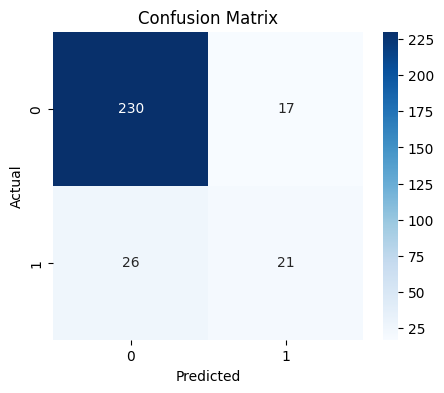

In [11]:
# Part 7 — Evaluate model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("✅ Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

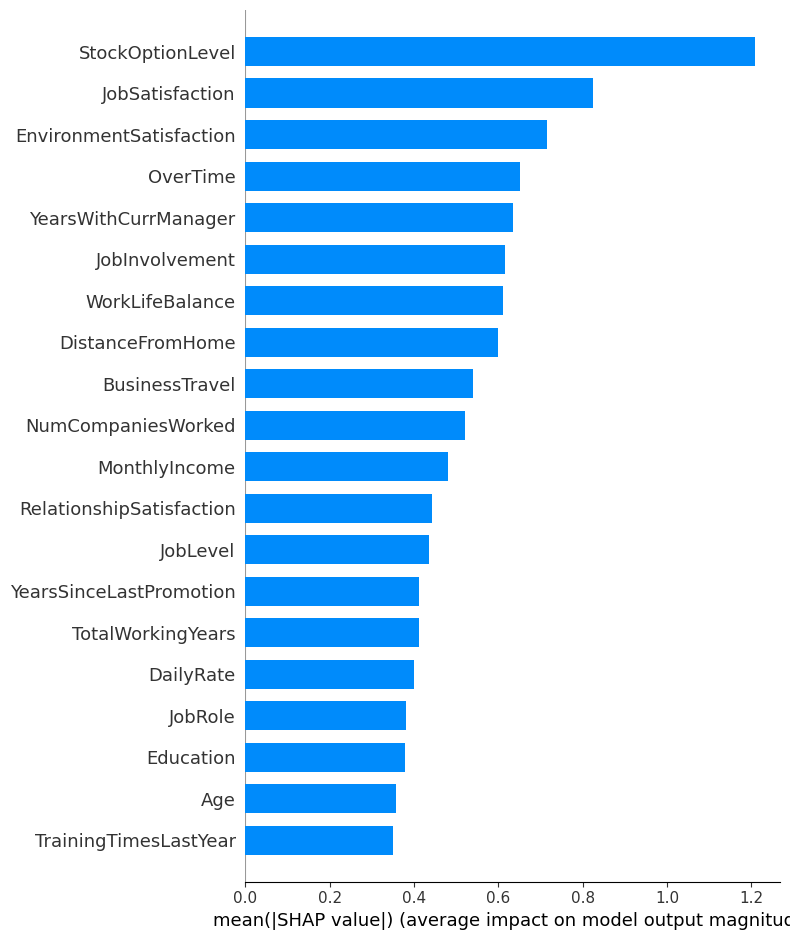

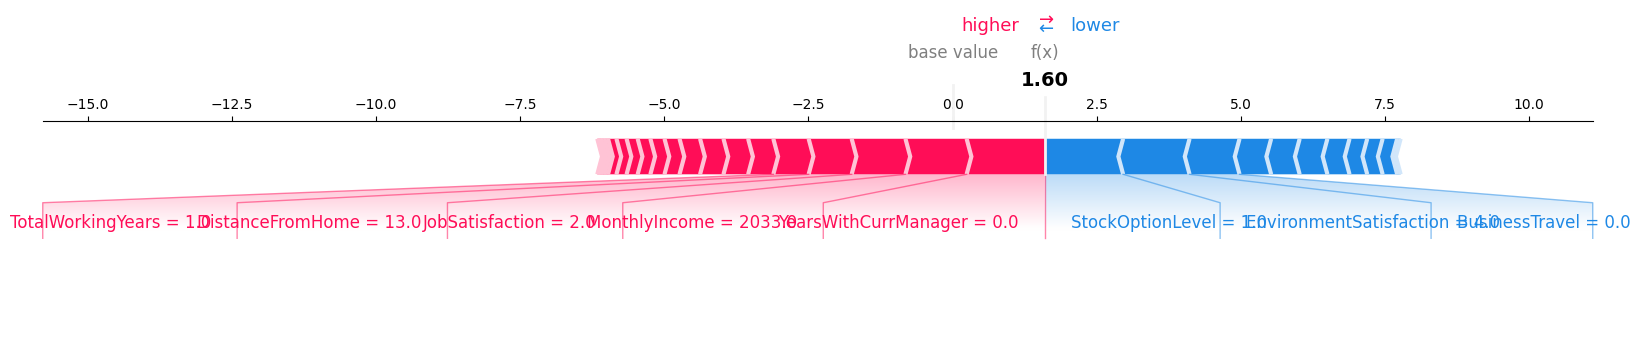

In [12]:
# Part 8 — SHAP Explainability
import shap
X_test_shap = X_test.astype(float)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_shap)

# Global importance
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

# Local explanation
sample = X_test_shap.iloc[0]
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, matplotlib=True)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

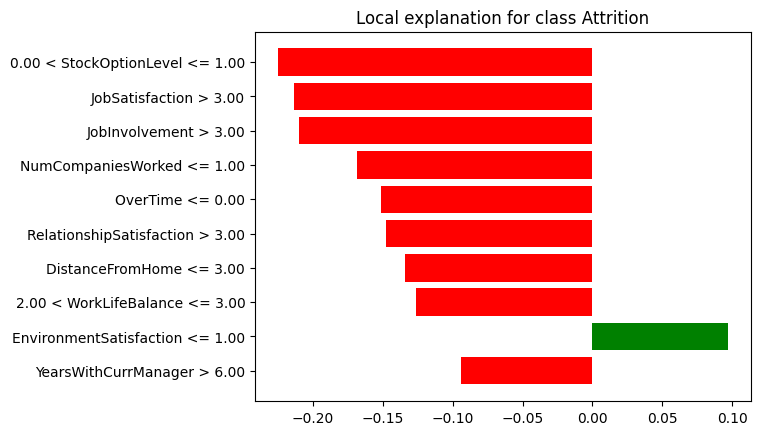

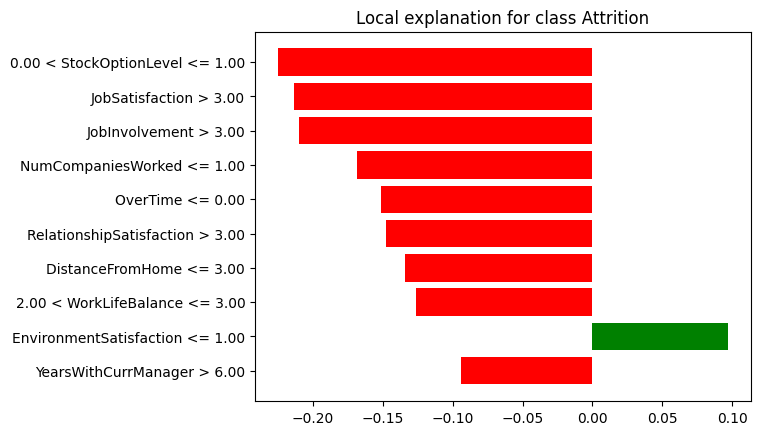

In [13]:
# Part 9 — LIME Explainability
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_bal),
    feature_names=X_train.columns,
    class_names=['No Attrition','Attrition'],
    mode='classification'
)

exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=model.predict_proba
)
exp.as_pyplot_figure()
